# Booster tune measure 

In this nootebook, I scratched some ideas to measure the betatron tunes of Sirius Booster accelerator using measures of beam position from BPM's.

I consider two aproximations:

1 - The BPM measures the center of the storaged bunch;

2 - The BPM measures directly the betatron oscillations, already discarding the closed orbit displacement.

With the treatment given here, we can only estimate the fractional part of the tunes.

For instance, only the second idea (section 4) gives a good answer to the problem, so you can jump directly to that. 

## Importing all necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaccel as pa 
import pymodels as pm

%config Completer.use_jedi = False #In my PC, the autocompletion only runs with jedi turned off.

# Creating the model and the bunch

In [2]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.cavity_on = True
bo.radiation_on = True
bo.vchamber_on = True

In [3]:
eq_params = pa.optics.EqParamsFromBeamEnvelope(bo)
emit1, emit2 = eq_params.emit1, np.abs(eq_params.emit2)
bo_et,_ = pa.optics.calc_edwards_teng(bo)
sigmas = eq_params.bunlen
sigmae = eq_params.espread0
bunch = pa.tracking.generate_bunch(emit1=emit1, emit2 = emit2, sigmae=sigmae, 
                                   sigmas=sigmas,optics = bo_et[0], n_part=1000)

#shifting the bunch to the closed orbit
co = pa.tracking.find_orbit6(accelerator=bo, indices='open')
bunch += co[:,[0]]

# First Idea: uses all BPM's 

This idea consists in tracking the particle oscillation around closed orbit at all BPM's and then apply a Discrete Fourier Transform to get the frequencies of oscillation. 

## Tracking the particles by one complete revolution

In [4]:
part_track, *_ = pa.tracking.line_pass(accelerator=bo, indices='open', particles=bunch, 
                                       parallel=True)

I am assuming that BPM measures the bunch center

In [5]:
bunch_center = np.nanmean(part_track,axis=1)
bunch_center.shape

(6, 2097)

Looking at of bunch center trajectory 

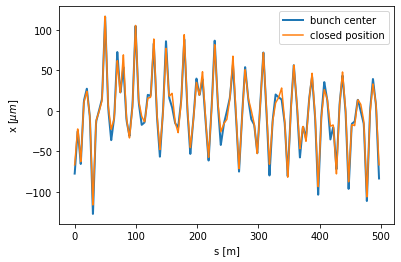

In [6]:
plt.plot(bo_et.spos,1e6*bunch_center[0,:], linewidth = 2, label="bunch center" )
plt.plot(bo_et.spos, 1e6*co[0,:],label = "closed position")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")
plt.legend()

Changing reference frame to catch only betatron oscillations

Text(0.5, 0, 's [m]')

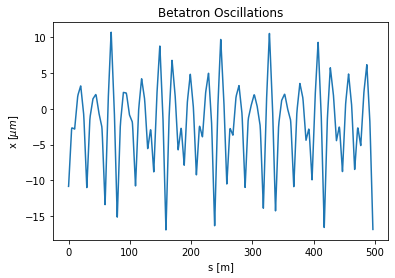

In [7]:
betatronx = bunch_center[0,:] - co[0,:]
plt.plot(bo_et.spos, betatronx*1e6)
plt.title("Betatron Oscillations")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")

## BPM measure

In [8]:
famdata = pm.bo.families.get_family_data(lattice=bo)
bpm_idx = famdata["BPM"]['index']

Text(0.5, 0, 's [m]')

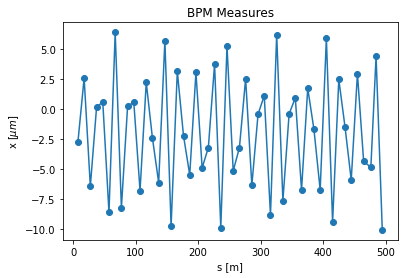

In [9]:
bpm_measure = betatronx[bpm_idx]
bpm_loc = bo_et.spos[bpm_idx]
plt.plot(bpm_loc,1e6*bpm_measure, linestyle="-", marker='o')
plt.title("BPM Measures")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")

To apply Discrete Fourier Transform, we need bpm measures equally spaced.

In [24]:
delta_s = np.diff(bpm_loc[:,0])
delta_s

EdwardsTengArray([ 9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749, 11.532029,  8.339469,  9.935749])

Okey, its almost equally spaced... But I will consider that it is.  

## Discrete Fourier Transform and signal processing

In [35]:
from numpy.fft import fft, fftfreq
from scipy.signal import find_peaks

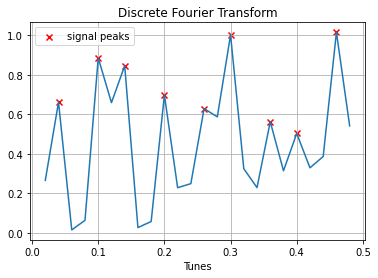

In [41]:
N = np.shape(bpm_measure)[0]

#Fourier Transform
yf = np.abs(fft(bpm_measure))
tunes = fftfreq(N)
mask = tunes>0
tunes, yf = tunes[mask], yf[mask]

yf_normalized = yf/(yf.max() - yf.min())

plt.plot(tunes, yf_normalized)
plt.title('Discrete Fourier Transform')
plt.xlabel('Tunes')
plt.grid(True)

# signal processing: finding proeminent peaks
peaks, properties = find_peaks(yf_normalized[:,0])
plt.scatter(tunes[peaks], yf_normalized[peaks], label="signal peaks", marker='x', c='r')
plt.legend()

In [42]:
print("Horizontal Tune:", eq_params.tune1)

Horizontal Tune: 0.20436768515806503


In [43]:
tunes[peaks]

array([0.04, 0.1 , 0.14, 0.2 , 0.26, 0.3 , 0.36, 0.4 , 0.46])

# Second Idea: Use a Single BPM 
This idea is based in the following equation

$x_j  = a \sqrt(\beta_0) cos(2 \pi \nu j + \phi_0)$

Which means that the betatron oscillation looked at a fixed azimuth behaves like a harmonic oscillation with an frequency $2\pi \nu$ in relation to the j-th passage.

## Tracking multiple turns of a particle at BPM location

Shifting the booster start point to the first BPM

In [49]:
bo2 = pa.lattice.shift(lattice=bo, start=bpm_idx[0][0])
print(bo2[0])

fam_name   : BPM 
pass_method: identity_pass 
hmin       : -0.018 m
hmax       : 0.018 m
vmin       : -0.018 m
vmax       : 0.018 m


Tracking using ring pass

In [52]:
turns = 100
part_rtrack, *_ = pa.tracking.ring_pass(accelerator=bo2,nr_turns=turns, particles = bunch,
                                        turn_by_turn=True, parallel=True)

Changing the reference to the closed orbit and measuring only the betatron oscillations

In [58]:
co2 = pa.tracking.find_orbit6(accelerator=bo2)
bunch_center2 = np.nanmean(part_rtrack, axis = 1)
betatronx_j = bunch_center2[0,:] - co2[0]

Text(0.5, 1.0, 'Betatron displacements at first BPM per turn ')

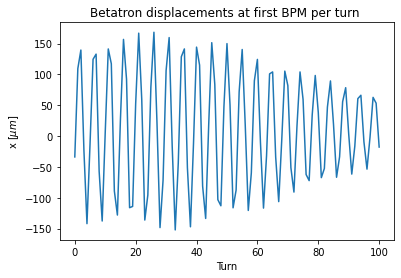

In [68]:
j_list = np.arange(turns+1)
plt.plot(j_list, 1e6*betatronx_j)
plt.xlabel('Turn')
plt.ylabel('x $[\mu m]$')
plt.title("Betatron displacements at first BPM per turn ")

## Fourier analysis again

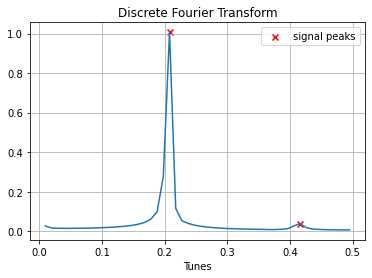

In [71]:
N=turns+1

#Fourier Transform
yf = np.abs(fft(betatronx_j))
tunes = fftfreq(N)
mask = tunes>0
tunes, yf = tunes[mask], yf[mask]

yf_normalized = yf/(yf.max() - yf.min())

plt.plot(tunes, yf_normalized)
plt.title('Discrete Fourier Transform')
plt.xlabel('Tunes')
plt.grid(True)

# signal processing: finding proeminent peaks
peaks, _ = find_peaks(yf_normalized)
plt.scatter(tunes[peaks], yf_normalized[peaks], label="signal peaks", marker='x', c='r')
plt.legend()

In [74]:
print(" Frequencies= {} \n Booster Horizontal Tune = {}".format(tuple(tunes[peaks]), eq_params.tune1))

 Frequencies= (0.2079207920792079, 0.4158415841584158) 
 Booster Horizontal Tune = 0.20436768515806503


I think that we need to improve the precision of this method because we will need to measure values of tune difference of order 0.01 or less. 